In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import fitClus2D as fc
from scipy.stats import sigmaclip
from astropy.stats import sigma_clip
from scipy.optimize import fmin_tnc

from sklearn.model_selection import LeaveOneOut
from sklearn.neighbors import KNeighborsClassifier, RadiusNeighborsClassifier
from sklearn. metrics import accuracy_score, mean_squared_error
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.neural_network import MLPClassifier
from sklearn import preprocessing
import pandas as pd

zclus = {'a2744' : 0.308,
         'm0416' : 0.396}
pgals = {'a2744' : [1.689791e-01, 1.965115e+00, 2.0],
        'm0416' : [3.737113e-01, 1.322081e+00, 2.0]}



In [2]:
cluster = 'a2744'
catalog = "Files/" + cluster + "_master_cleaned.csv"

dzcut=0.03; sigclip=3; sigcut=3; radialcut=120; maglim=23.5; colorcut=1.0
master = pd.read_csv(catalog)
zdat = master['master_z']
valid = master['master_valid']
memberindx = np.where((zdat>zclus[cluster]-dzcut)&(zdat<zclus[cluster]+dzcut)&(valid==1))[0]
z1 = zdat[memberindx]
z2 = sigma_clip(z1,sigma=sigclip)
print(np.mean(z2),np.std(z2))

dz = sigcut*np.std(z2)
print(dz)
ddat = master['master_d']
zdat = master['master_z']
mag814 = master['master_mag814']
mag606 = master['master_mag606']
valid = master['master_valid']
master_cut = master.iloc[np.where((ddat<radialcut)&(~np.isnan(mag606))&(~np.isnan(mag814))&(mag814<=maglim)&(valid == 1))]

zdat   = master_cut['master_z']
nmemindx = np.where((zdat<zclus[cluster]-dz)|(zdat>zclus[cluster]+dz))[0]
memindx = np.where((zdat>zclus[cluster]-dz)&(zdat<zclus[cluster]+dz))[0]
unknownindx = np.where(np.isnan(zdat))[0]

print(len(memindx))
print(len(nmemindx))
print(len(unknownindx))
clusterarr = [master_cut.iloc[i] for i in memindx]
ncluster =[master_cut.iloc[i] for i in nmemindx]
unknown = [master_cut.iloc[i] for i in unknownindx]

0.3069860850098326 0.007357462290748165
0.022072386872244495
92
46
235


In [3]:
XclustCM= [[row['master_mag814'], row['master_mag606'] - row['master_mag814']] for row in clusterarr]
XnclustCM = [[row['master_mag814'], row['master_mag606'] - row['master_mag814']] for row in ncluster]
Xcm = np.array(XclustCM + XnclustCM)

Xclustall= [[row['master_mag814'], row['master_mag606'] - row['master_mag814'], row['master_d']] for row in clusterarr]
Xnclustall = [[row['master_mag814'], row['master_mag606'] - row['master_mag814'], row['master_d']] for row in ncluster]
Xall = np.array(Xclustall + Xnclustall)

unknownXcm = [[row['master_mag814'], row['master_mag606'] - row['master_mag814']] for row in unknown]
unknownXcm = np.array(unknownXcm)

y = np.zeros(len(clusterarr) + len(ncluster))
y[:len(clusterarr)] = 1

minm = np.min(Xcm[:,0])
maxm = np.max(Xcm[:,0])

minc = np.min(Xcm[:,1])
maxc = np.max(Xcm[:,1])

#Expand borders by 1 percent
w = maxm - minm
h = maxc - minc

minm -= 0.01 * w
maxm += 0.01 * w
minc -= 0.01 * h
maxc += 0.01 * h


In [4]:
#Normalize 2D data to be between 0 and 1 in every column
def normalize(arr):
    copy = np.zeros((len(arr), len(arr[0])))
    for i in range((len(arr[0]))):
        copy[:,i] = (arr[:,i] - np.min(arr[:,i])) / (np.max(arr[:,i]) - np.min(arr[:,i]))
    
    return copy

#K nearest neighbors classification, returns probabilities for unknowns, classes for unknowns
def Knn(X, y, p, k):
    model = KNeighborsClassifier(n_neighbors = k)
    model.fit(X, y)
    return model.predict_proba(p)[:,1], model.predict(p)

def weightedKnn(X, y, p, k):
    model = KNeighborsClassifier(n_neighbors = k, weights = 'distance')
    model.fit(X, y)
    return model.predict_proba(p)[:,1], model.predict(p)

def Rnn(X, y, p, r):
    model = RadiusNeighborsClassifier(radius = r, outlier_label = 0)
    model.fit(X, y)
    return model.predict_proba(p)[:,1], model.predict(p)

def neuralNetwork(X, y, p):
    model = MLPClassifier(hidden_layer_sizes=(2), alpha = 0.1, max_iter=2000)
    model.fit(X, y)
    return model.predict_proba(p)[:,1], model.predict(p)

def includeNone(X, y, p):
    return np.zeros(len(p)), np.zeros(len(p))


def includeAll(X, y, p):
    return np.full((len(p)), 1.0), np.full((len(p)), 1.0)

#Assign probabilities based on sigma cut from line of best fit for cluster members
def sigmaCut(X, y, p, k):
    clustermag = [dat[0] for i, dat in enumerate(X) if y[i] == 1]
    clustercolor = [dat[1] for i, dat in enumerate(X) if y[i] == 1]
    
    model = np.polyfit(clustermag, clustercolor, 1)
    predict = np.poly1d(model)
    
    res = clustercolor - predict(clustermag)
    sigma = np.std(res)
    
    probs = np.zeros(len(p))
    classes = np.zeros(len(p))
    
    nclust = 0
    ntot = 0
    
    for i, point in enumerate(X):
        if abs(point[1] - predict(point[0])) < k * sigma:
            if y[i] == 1:
                nclust += 1
            ntot += 1
    prob = nclust / ntot
    
    for i, point in enumerate(p):
        if abs(point[1] - predict(point[0])) < k * sigma:
               probs[i] = prob
               classes[i] = 1
    return probs, classes

def logistic(X, y, p):
    model = LogisticRegression()
    model.fit(X, y)
    
    return model.predict_proba(p)[:,1], model.predict(p)

def SVM(X, y, p):
    model = svm.SVC(kernel='linear', probability = True)
    model.fit(X, y)
    
    return model.predict_proba(p)[:,1], model.predict(p) 

#Have some global variables for box to speed up runtime
grid = []
prevx = []
prevy = []

def initBox():
    global grid, prevx, prevy
    grid = np.zeros((0, 0, 2))
    prevx = []
    prevy = []

def box(X, y, p, py, numx, numy):
    global grid, prevx, prevy
    w = (maxm - minm) / numx
    h = (maxc - minc) / numy
    
    #If this is a new grid, set prevx and prevy to be X and y. Else, have to eliminate the current points p from the old grid
    if (not numx == grid.shape[0]) or (not numy == grid.shape[1]):
        grid = np.zeros((numx, numy, 2))
        prevx = X
        prevy = y
    
    else:
        for i, point in enumerate(p):
            xcoor = int((point[0] - minm) / w)
            ycoor = int((point[1] - minc) / h)
            grid[xcoor, ycoor, 1] -= 1
            grid[xcoor, ycoor, 0] -= py[i]
    
    #add back previous points, or add all the points if this is a new grid
    for i, point in enumerate(prevx):
        xcoor = int((point[0] - minm) / w)
        ycoor = int((point[1] - minc) / h)
        grid[xcoor, ycoor, 1] += 1
        grid[xcoor, ycoor, 0] += prevy[i]
    
    probs = np.zeros(len(p))
    classes = np.zeros(len(p))
    for i, point in enumerate(p):
        xcoor = int((point[0] - minm) / w)
        ycoor = int((point[1] - minc) / h)
        if not grid[xcoor, ycoor, 1] == 0:
            probs[i] = grid[xcoor, ycoor, 0] / grid[xcoor, ycoor, 1]
            if probs[i] > 0.5: classes[i] = 1
    prevx = p
    prevy = py
    return probs, classes
    
model_dict = {
    'Knn' : Knn,
    'weightedKnn' : weightedKnn,
    'includeNone' : includeNone,
    'includeAll' : includeAll,
    'sigmaCut' : sigmaCut,
    'logistic' : logistic,
    'SVM' : SVM,
    "box" : box,
    "Rnn" : Rnn,
    "neuralNetwork" : neuralNetwork
}

#Uses Leave one out Cross validation to return rms of probabilities for a given model, and accuracy of classifier
#X is data for each galaxy, y is whether or not galaxy is in the cluster
def testPerformance(X, y, model, k=-1, numy = -1):
    loo = LeaveOneOut()
    
    testprobs = []
    testclass = []
    
    for train, test in loo.split(X):
        train_X = X[train]
        test_X = X[test]
        train_y = y[train]
        test_y = y[test]
        
        if numy != -1:
            ret = model_dict[model](train_X, train_y, test_X, test_y, k, numy)
            
        elif k != -1:
            ret = model_dict[model](train_X, train_y, test_X, k)
            
        else:
            ret = model_dict[model](train_X, train_y, test_X)
        
        testprobs.append(ret[0][0])
        testclass.append(ret[1][0])
    
    return mean_squared_error(y, testprobs), accuracy_score(y, testclass)



In [5]:
sigmaclass = sigmaCut(Xcm, y, unknownXcm, 1)[1]
print(np.sum(sigmaclass))

163.0


(0.2318840579710145, 0.7681159420289855)
(0.17028985507246377, 0.7463768115942029)
(0.16425120772946863, 0.8043478260869565)
(0.14583333333333334, 0.8115942028985508)
(0.1394202898550725, 0.7971014492753623)
(0.13989533011272143, 0.8188405797101449)
(0.13368825791186037, 0.8260869565217391)
(0.13168025362318841, 0.8333333333333334)
(0.1328502415458937, 0.8333333333333334)
(0.1303623188405797, 0.8260869565217391)
(0.12744041202539225, 0.8405797101449275)
(0.1259561191626409, 0.8405797101449275)
(0.1280336163279307, 0.8478260869565217)
(0.1268485655131618, 0.8478260869565217)
(0.12814814814814815, 0.8478260869565217)
(0.12986865942028986, 0.8478260869565217)
(0.12988315530815908, 0.8478260869565217)
(0.13077026301663983, 0.8478260869565217)
(0.12925047171705004, 0.8478260869565217)
(0.12681159420289856, 0.8478260869565217)
(0.12673765158237205, 0.8478260869565217)
(0.1280842017008025, 0.8478260869565217)
(0.12932522396646667, 0.8478260869565217)
(0.1305102657004831, 0.8478260869565217)
(

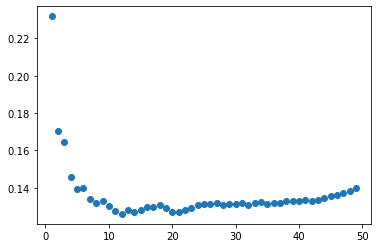

In [39]:
results = []
scaler = preprocessing.MinMaxScaler().fit(Xcm)
normXcm = scaler.fit_transform(Xcm)

for k in range(1, 50):
    ret = testPerformance(normXcm, y, "Knn", k)
    print(ret)
    results.append(ret)

results = np.array(results)
ks = range(1, 50)

plt.scatter(ks, results[:,0])

ind = np.argmin(results[:,0])
print(ks[ind])
print(results[ind])

(0.5289855072463768, 0.47101449275362317)
(0.411231884057971, 0.5797101449275363)
(0.2947363123993559, 0.6811594202898551)
(0.23852455716586152, 0.7463768115942029)
(0.21262778988629377, 0.782608695652174)
(0.19086355890224727, 0.7971014492753623)
(0.16380265986029852, 0.8188405797101449)
(0.1514232735873801, 0.8260869565217391)
(0.13962391552557846, 0.8188405797101449)
(0.1360572751012317, 0.8188405797101449)
(0.13476095002729788, 0.8260869565217391)
(0.1427437646435363, 0.8115942028985508)
(0.14948767072238756, 0.8115942028985508)
(0.14714414424272024, 0.8188405797101449)
(0.13995425719766932, 0.8188405797101449)
(0.1426376883144903, 0.8188405797101449)
(0.1425854855570438, 0.8333333333333334)
(0.13206328633135764, 0.8405797101449275)
(0.12733359867192753, 0.8405797101449275)
(0.1284441987844213, 0.8405797101449275)
(0.128544165213657, 0.8478260869565217)
(0.12802610417352964, 0.855072463768116)
(0.127230667430969, 0.855072463768116)
(0.12360121868394093, 0.855072463768116)
(0.122624

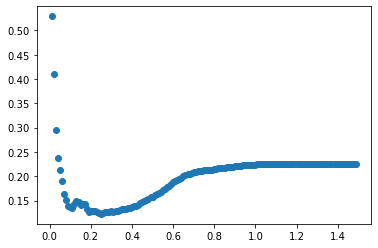

In [27]:
results = []
scaler = preprocessing.MinMaxScaler().fit(Xcm)
normXcm = scaler.fit_transform(Xcm)


for r in np.arange(0.01, 1.5, 0.01):
    ret = testPerformance(normXcm, y, "Rnn", r)
    print(ret)
    results.append(ret)

results = np.array(results)
ks = np.arange(0.01, 1.5, 0.01)

plt.scatter(ks, results[:,0])

ind = np.argmin(results[:,0])
print(ks[ind])
print(results[ind])


In [28]:
print(testPerformance(Xcm, y, "includeAll"))
print(testPerformance(Xcm, y, "includeNone"))

(0.3333333333333333, 0.6666666666666666)
(0.6666666666666666, 0.3333333333333333)


(0.17588368554319705, 0.7584745762711864)
(0.1531231633791037, 0.7838983050847458)
(0.14736065493286768, 0.788135593220339)
(0.14485849408650073, 0.7923728813559322)
(0.14409085606871339, 0.7966101694915254)
(0.14604644357278657, 0.7796610169491526)
(0.14292724168983204, 0.7838983050847458)
(0.1428908443190663, 0.8008474576271186)
(0.1417632199201909, 0.7838983050847458)
(0.14593905115738112, 0.7669491525423728)
(0.1456066935902716, 0.7838983050847458)
(0.1448791250816518, 0.7838983050847458)
(0.1451651707565212, 0.7838983050847458)
(0.14468461695994833, 0.7838983050847458)
(0.1428886621192958, 0.7796610169491526)
(0.14231117031434407, 0.788135593220339)
(0.14114888287071392, 0.7838983050847458)
(0.1406767518973673, 0.7923728813559322)
(0.14119755728375957, 0.7923728813559322)
(0.14040388250647298, 0.8008474576271186)
(0.13905224947131123, 0.8008474576271186)
(0.1391620125532852, 0.809322033898305)
(0.13784751255365132, 0.8050847457627118)
(0.13716683752307682, 0.7966101694915254)
(0.1

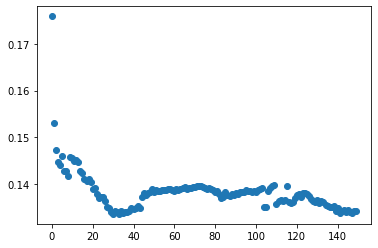

In [5]:

# results = []
# params = []
# scaledXcm = np.copy(normXcm)

# for scale in np.arange(0.1, 15.1, 0.1):
#     scaledXcm[:,1] = scale*normXcm[:,1]
#     bestr = 0
#     mn = [10, 0]
#     for r in np.arange(0.01, 1.5, 0.01):
#         ret = testPerformance(Xcm, y, "Rnn", r)
#         if mn[0] > ret[0]:
#             bestr = r
#             mn = ret
#     params.append([scale, bestr])  
#     results.append(mn)
#     print(mn)
        

# results = np.array(results)
# ks = np.arange(len(results))

# ind = np.argmin(results[:,0])

# plt.scatter(ks, results[:,0])
# print(params[ind])
# print(results[ind])

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
3
5
[0.12576979 0.85507246]


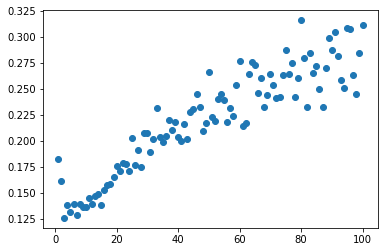

In [29]:
initBox()
results = []
indices = []
for i in range(1, 101):
    print(i)
    mn = [10, 0]
    bestj = 0
    for j in range(1, 101):
        ret = testPerformance(Xcm, y, "box", i, j)
        if mn[0] > ret[0]:
            bestj = j
            mn = ret
    results.append(mn)
    indices.append(bestj)

results = np.array(results)
xax = np.arange(1, 101)
plt.scatter(xax, results[:,0])

ind = np.argmin(results[:,0])
print(ind + 1)
print(indices[ind])
print(results[ind])



(0.6208527967421248, 0.37681159420289856)
(0.5988593118406783, 0.391304347826087)
(0.5135208001966078, 0.47101449275362317)
(0.4817531452315226, 0.4927536231884058)
(0.4052791992723905, 0.5652173913043478)
(0.35035731656588853, 0.6159420289855072)
(0.30286593993927563, 0.6666666666666666)
(0.26274846454806317, 0.7028985507246377)
(0.23378262389734453, 0.7318840579710145)
(0.22074288366691616, 0.7391304347826086)
(0.21798914634540126, 0.7391304347826086)
(0.21973045580566145, 0.7318840579710145)
(0.22369311615759646, 0.7246376811594203)
(0.22381782576622944, 0.7246376811594203)
(0.22087711549242323, 0.7246376811594203)
(0.22109781708819845, 0.7246376811594203)
(0.22290536421180548, 0.717391304347826)
(0.2192367260782134, 0.717391304347826)
(0.2200813815316111, 0.717391304347826)
(0.226706893547051, 0.7028985507246377)
(0.23196184205659912, 0.6956521739130435)
(0.2273671861364312, 0.6956521739130435)
(0.22741668031738643, 0.6956521739130435)
(0.22821073314246856, 0.6956521739130435)
(0.2

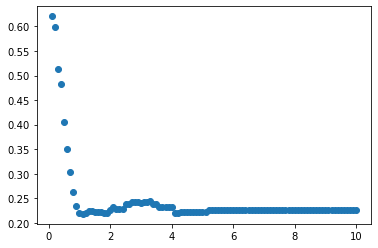

In [30]:
results = []
for k in np.arange(0.1, 10.1, 0.1):
    ret = testPerformance(Xcm, y, "sigmaCut", k)
    print(ret)
    results.append(ret)

results = np.array(results)
ks = np.arange(0.1, 10.1, 0.1)

plt.scatter(ks, results[:,0])

In [6]:
print(testPerformance(Xcm, y, "logistic"))

print(testPerformance(Xall, y, "logistic"))

print(testPerformance(Xcm, y, "SVM"))

(0.13054430281775017, 0.8478260869565217)
(0.13057246906619305, 0.8478260869565217)
(0.13311933952382018, 0.8405797101449275)


In [33]:
normXall = normalize(Xall)
print(testPerformance(normXall, y, "neuralNetwork"))

C:\Users\Jackson Lee\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Jackson Lee\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Jackson Lee\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Jackson Lee\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Jackson Lee\Anaconda3\lib\site-pack

(0.1937222889542167, 0.717391304347826)
